# Credit Risk Resampling Techniques

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

# Read the CSV and Perform Basic Data Cleaning

In [3]:
columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [186]:
# Load the data
file_path = Path('C:/Users/Endalkachew Desta/downloads/Classification_HW/LoanStats_2019Q1.csv.zip')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


In [276]:
#Converting dates to numerical 
for col in ['issue_d', 'next_pymnt_d']:
    df[col] = pd.DatetimeIndex(df[col]).astype(np.int64)*1e-9
# Converting categorical values to numerical
df = df.replace(['OWN','RENT','Source Verified', 'Verified','n','w', 'f','Individual','N'],1)

df = df.replace(['MORTGAGE','ANY','Not Verified','Joint App'],0)
df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,0,66000.0,0,1.551398,low_risk,0,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,1,1
1,25000.0,0.2000,929.09,1,105000.0,0,1.551398,low_risk,0,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,1,1
2,20000.0,0.2000,529.88,1,56000.0,0,1.551398,low_risk,0,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,1,1
3,10000.0,0.1640,353.55,0,92000.0,0,1.551398,low_risk,0,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,1,1
4,22000.0,0.1474,520.39,1,52000.0,1,1.551398,low_risk,0,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,1,1


# Split the Data into Training and Testing

In [277]:
# Create our features
x_cols = [i for i in df.columns if i not in ("loan_status")]
X = df[x_cols]

# Create our target
y = df["loan_status"]

In [278]:
X.describe()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,dti,delinq_2yrs,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
count,68817.000000,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.0,68817.000000,68817.000000,...,68817.000000,68817.000000,68817.000000,68817.0,6.881700e+04,6.881700e+04,68817.000000,6.881700e+04,68817.0,68817.0
mean,16677.594562,0.127718,480.652863,0.535594,8.821371e+04,0.478007,1.548200,0.0,21.778153,0.217766,...,95.057627,30.626217,0.125972,0.0,2.100332e+05,6.133843e+04,29734.128558,5.572240e+04,1.0,1.0
std,10277.348590,0.048130,288.062432,0.498735,1.155800e+05,0.499520,0.001915,0.0,20.199244,0.718367,...,8.326426,33.631463,0.336732,0.0,1.928088e+05,5.738798e+04,26795.394232,5.095845e+04,0.0,0.0
min,1000.000000,0.060000,30.890000,0.000000,4.000000e+01,0.000000,1.546301,0.0,0.000000,0.000000,...,20.000000,0.000000,0.000000,0.0,3.600000e+03,2.350000e+02,100.000000,1.270000e+02,1.0,1.0
25%,9000.000000,0.088100,265.730000,0.000000,5.000000e+04,0.000000,1.546301,0.0,13.890000,0.000000,...,93.000000,0.000000,0.000000,0.0,6.697700e+04,2.650300e+04,11600.000000,2.288000e+04,1.0,1.0
50%,15000.000000,0.118000,404.560000,1.000000,7.300000e+04,0.000000,1.548979,0.0,19.760000,0.000000,...,100.000000,20.000000,0.000000,0.0,1.467100e+05,4.535700e+04,22100.000000,4.200000e+04,1.0,1.0
75%,24000.000000,0.155700,648.100000,1.000000,1.040000e+05,1.000000,1.548979,0.0,26.660000,0.000000,...,100.000000,50.000000,0.000000,0.0,3.036400e+05,7.657000e+04,39300.000000,7.249900e+04,1.0,1.0
max,40000.000000,0.308400,1676.230000,1.000000,8.797500e+06,1.000000,1.551398,0.0,999.000000,18.000000,...,100.000000,100.000000,4.000000,0.0,3.292782e+06,1.295455e+06,509400.000000,1.426964e+06,1.0,1.0


In [279]:
y = pd.DataFrame(y, columns=['loan_status'])

In [280]:
# Check the balance of our target values
y['loan_status'].value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [281]:
# Create X_train, X_test, y_train, y_test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

## Data Pre-Processing

Scale the training and testing data using the `StandardScaler` from `sklearn`. Remember that when scaling the data, you only scale the features data (`X_train` and `X_testing`).

In [282]:
# Create the StandardScaler instance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [283]:
# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset

X_scaler = scaler.fit(X_train)

In [284]:
# Scale the training and testing data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Oversampling

In this section, you will compare two oversampling algorithms to determine which algorithm results in the best performance. You will oversample the data using the naive random oversampling algorithm and the SMOTE algorithm. For each algorithm, be sure to complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

### Naive Random Oversampling

In [285]:
# Resample the training data with the RandomOversampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from imblearn.metrics import classification_report_imbalanced

ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
Counter(y_resampled['loan_status'])

Counter({'low_risk': 51352, 'high_risk': 51352})

In [286]:
# Train the Logistic Regression model using the resampled data
X_resampled = X_resampled.dropna(axis=1)

model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [287]:
# Display the confusion matrix
y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[   53,    34],
       [ 4858, 12260]], dtype=int64)

In [288]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.6627002832267708

In [289]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.61      0.72      0.02      0.66      0.43        87
   low_risk       1.00      0.72      0.61      0.83      0.66      0.44     17118

avg / total       0.99      0.72      0.61      0.83      0.66      0.44     17205



### SMOTE Oversampling

In [290]:
# Resample the training data with SMOTE
from imblearn.over_sampling import SMOTE

X_resampled, y_resampled = SMOTE(random_state=1, sampling_strategy=1.0).fit_resample(
    X_train, y_train
)
from collections import Counter

Counter(y_resampled['loan_status'])

Counter({'low_risk': 51352, 'high_risk': 51352})

In [291]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [292]:
# Calculated the balanced accuracy score
y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.6758745583394773

In [293]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[   57,    30],
       [ 5194, 11924]], dtype=int64)

In [294]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.66      0.70      0.02      0.68      0.45        87
   low_risk       1.00      0.70      0.66      0.82      0.68      0.46     17118

avg / total       0.99      0.70      0.66      0.82      0.68      0.46     17205



# Undersampling

In this section, you will test an undersampling algorithms to determine which algorithm results in the best performance compared to the oversampling algorithms above. You will undersample the data using the Cluster Centroids algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [295]:
# Resample the data using the ClusterCentroids resampler
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(random_state=1)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)

from collections import Counter

Counter(y_resampled)

Counter({'loan_status': 1})

In [296]:
# Train the Logistic Regression model using the resampled data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from imblearn.metrics import classification_report_imbalanced
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [297]:
# Calculated the balanced accuracy score
y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.5492746091027392

In [298]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[  54,   33],
       [8938, 8180]], dtype=int64)

In [299]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.62      0.48      0.01      0.54      0.30        87
   low_risk       1.00      0.48      0.62      0.65      0.54      0.29     17118

avg / total       0.99      0.48      0.62      0.64      0.54      0.29     17205



# Combination (Over and Under) Sampling

In this section, you will test a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above. You will resample the data using the SMOTEENN algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [300]:
# Resample the training data with SMOTEENN
from imblearn.combine import SMOTEENN

sm = SMOTEENN(random_state=1)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
Counter(y_resampled['loan_status'])

Counter({'high_risk': 51337, 'low_risk': 46253})

In [301]:
# Train the Logistic Regression model using the resampled data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [302]:
# Calculated the balanced accuracy score
y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)


0.6695956263018158

In [303]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[   61,    26],
       [ 6196, 10922]], dtype=int64)

In [304]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.70      0.64      0.02      0.67      0.45        87
   low_risk       1.00      0.64      0.70      0.78      0.67      0.44     17118

avg / total       0.99      0.64      0.70      0.77      0.67      0.44     17205



[Text(0, 0, 'pre'),
 Text(1, 0, 'rec'),
 Text(2, 0, 'spe'),
 Text(3, 0, 'f1'),
 Text(4, 0, 'geo'),
 Text(5, 0, 'iba'),
 Text(6, 0, 'b_accuracy')]

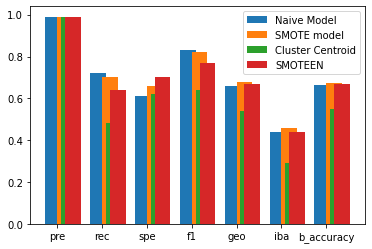

In [309]:
Naive_model = {'Report':['pre','rec','spe','f1','geo','iba','b_accuracy'],'values':[.99,.72,.61,.83,.66,.44,.6627]}
smot_model = {'Report':['pre','rec','spe','f1','geo','iba','b_accuracy'],'values':[.99,.70,.66,.82,.68,.46,.6759]}
cluster_model = {'Report':['pre','rec','spe','f1','geo','iba','b_accuracy'],'values':[.99,.48,.62,.64,.54,.29,.5493]}
combo_model = {'Report':['pre','rec','spe','f1','geo','iba','b_accuracy'],'values':[.99,.64,.70,.77,.67,.44,.6696]}

df_naive = pd.DataFrame(Naive_model) 
df_smot = pd.DataFrame(smot_model) 
df_cluster = pd.DataFrame(cluster_model) 
df_combo = pd.DataFrame(combo_model) 

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
width=0.35
x = np.arange(len(df_naive['Report']))  # the label locations
rects1 = ax.bar(x - width/4, df_naive['values'], width, label='Naive Model')
rects2 = ax.bar(x + width/2, df_smot['values'], width, label='SMOTE model')
rects3 = ax.bar(x + width*.75, df_cluster['values'], width, label='Cluster Centroid')
rects4 = ax.bar(x + width, df_combo['values'], width, label='SMOTEEN')
ax.legend()
ax.set_xticks(x)
ax.set_xticklabels(df_naive['Report'])